In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import fasttreeshap
import shap
import pickle
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors
import timeit
from joblib import Parallel, delayed
shap.initjs()

In [ ]:
data = pd.read_csv("../data_sets/scaled_annual_data_JFE.csv")
y = data.iloc[:,2]
X = data.iloc[:,3:]
Dates = data.iloc[:,1]

In [ ]:
model = RandomForestRegressor(n_estimators = 100, 
                              max_features = 17,
                              random_state = 1011)
model.fit(X, y)

RandomForestRegressor(max_features=17, random_state=1011)

In [ ]:
explainer = fasttreeshap.TreeExplainer(model, algorithm = "v1", n_jobs = -1)

In [ ]:
""" # 以并行模式获取 SHAP 交互值
start = timeit.default_timer()

def get_shap_interactions(explainer,X,i):
    shap_interaction = explainer(X.iloc[i,:],interactions = True).values
    return shap_interaction

shap_interaction = Parallel(n_jobs=-1)(delayed(get_shap_interactions)(explainer,X,i) for i in range(np.shape(X)[0]))

# 保存 SHAP 交互值
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # 覆盖任何现有文件
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# 示例用法
save_object(shap_interaction, 'shap_interactions_scaled_vars_RF.pkl')

# 获取变量主效应的 SHAP 值
shap_values = explainer(X,interactions = False).values

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # 覆盖任何现有文件
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        
save_object(shap_values, 'shap_values_scaled_vars_RF.pkl')

stop = timeit.default_timer()
print('耗时: ', stop - start) """


#### Interacion importance

In [ ]:
# 加载 SHAP 交互值
with open('shap_interactions_scaled_vars_RF.pkl', 'rb') as f:
    # 协议版本会自动检测，无需手动指定
    shap_interaction = pickle.load(f)

In [ ]:
# 计算矩阵的绝对均值
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# 对非对角线元素乘以 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

In [ ]:
# 绘制交互值的柱状图

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of SHAP interaction matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_interactions(df):
    au_corr = df.unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

interaction_bar_plot = get_interactions(df)

interaction_bar_plot = interaction_bar_plot[0:29].sort_values(ascending=True)

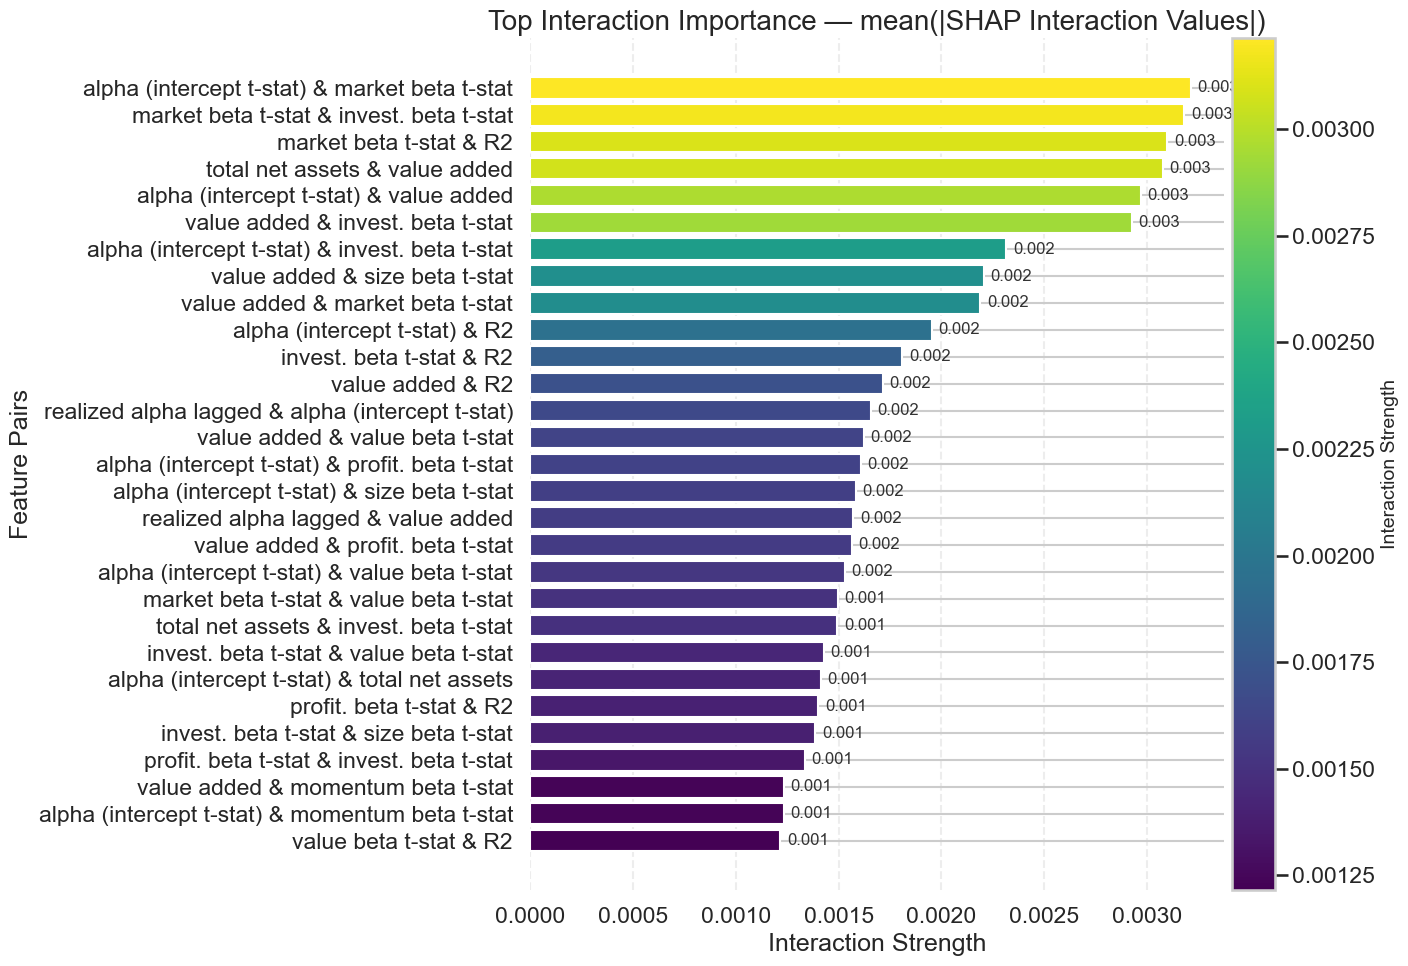

In [ ]:
interaction_bar_plot = interaction_bar_plot[0:29].sort_values(ascending=False)
feature_pairs = [' & '.join(pair) for pair in interaction_bar_plot.index]
values = interaction_bar_plot.values

cmap = plt.cm.viridis
norm = plt.Normalize(values.min(), values.max())
colors = cmap(norm(values))

fig, ax = plt.subplots(figsize=(14, 10))
bars = ax.barh(feature_pairs, values, color=colors)
ax.invert_yaxis()

ax.set_xlabel('Interaction Strength', fontsize=18)
ax.set_ylabel('Feature Pairs', fontsize=18)
ax.set_title('Top Interaction Importance — mean(|SHAP Interaction Values|)', fontsize=20)

ax.grid(axis='x', linestyle='--', alpha=0.35)
sns.despine(left=True, bottom=True)

max_val = values.max()
for i, (pair, val) in enumerate(zip(feature_pairs, values)):
    ax.text(val + max_val * 0.01, i, f'{val:.3f}', 
            va='center', fontsize=12, color='#333')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label('Interaction Strength', fontsize=14)

plt.tight_layout()
plt.savefig("interaction_importance_SHAP_RF.pdf", format="pdf", bbox_inches="tight")